In [1]:
import pystac_client
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from itertools import compress
import pandas as pd

In [2]:
# opening STAC catalog

catalog = pystac_client.Client.open(
    #"https://storage.googleapis.com/dgds-data-public/coclico/coclico-stac/catalog.json" # cloud API
    r"p:\1000545-054-globalbeaches\15_GlobalCoastalAtlas\coclicodata\current\catalog.json" # P drive API 
)
#catalog

In [3]:
list(catalog.get_children())

[<CollectionClient id=ssl>,
 <CollectionClient id=wef>,
 <CollectionClient id=eesl>,
 <CollectionClient id=floodmaps>,
 <CollectionClient id=sc>,
 <CollectionClient id=cbca>,
 <CollectionClient id=cfr>,
 <CollectionClient id=cm>,
 <CollectionClient id=smd>,
 <CollectionClient id=cisi>,
 <CollectionClient id=shore_mon>,
 <CollectionClient id=shore_mon_hr>,
 <CollectionClient id=shore_mon_fut>]

# Annual Shoreline Monitor

In [4]:
href = catalog.get_child("shore_mon").assets["data"].href

In [5]:
ds = xr.open_zarr(href)

In [6]:
ds

<xarray.Dataset>
Dimensions:             (stations: 1837203, time: 38)
Coordinates: (12/18)
    coastline_idint     (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
    continent           (stations) |S23 dask.array<chunksize=(28707,), meta=np.ndarray>
    country             (stations) |S40 dask.array<chunksize=(28707,), meta=np.ndarray>
    country_id          (stations) |S7 dask.array<chunksize=(114826,), meta=np.ndarray>
    err_changerate      (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
    err_timespan        (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
    ...                  ...
    no_shorelines       (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
    rmse                (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
  * time                (time) datetime64[ns] 1984-01-01 ... 2021-01-01
    timespan            (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
    transect_geom       (stations) |S92 dask.array<chunksize=(14354,), meta=np.ndarray>
    transect_id         (stations) |S15 dask.array<chunksize=(57413,), meta=np.ndarray>
Dimensions without coordinates: stations
Data variables:
    changerate          (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
    changerate_unc      (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
    outliers            (stations, time) float32 dask.array<chunksize=(114826, 3), meta=np.ndarray>
    sandy               (stations) int8 dask.array<chunksize=(459301,), meta=np.ndarray>
    sp                  (stations, time) float64 dask.array<chunksize=(57413, 3), meta=np.ndarray>
Attributes: (12/21)
    AUTHOR:              Luijendijk, A., Hagenaars, G., Ranasinghe, R., Baart...
    CITATION:            Luijendijk, A., Hagenaars, G., Ranasinghe, R. et al....
    COMMENT:             
    CRS:                 EPSG:4326
    Conventions:         CF-1.8
    DESCRIPTION:         The Shoreline Monitor is a dataset that incorporates...
    ...                  ...
    SPATIAL_EXTENT:      [-180, -90, 180, 90]
    TAGS:                ['civil engineering', 'geomorphology', 'shoreline dy...
    TEMPORAL_EXTENT:     ['1984-01-01T00:00:00Z', '2021-01-01T00:00:00Z']
    TITLE:               The Shoreline Monitor
    TITLE_ABBREVIATION:  shore_mon
    UNITS:

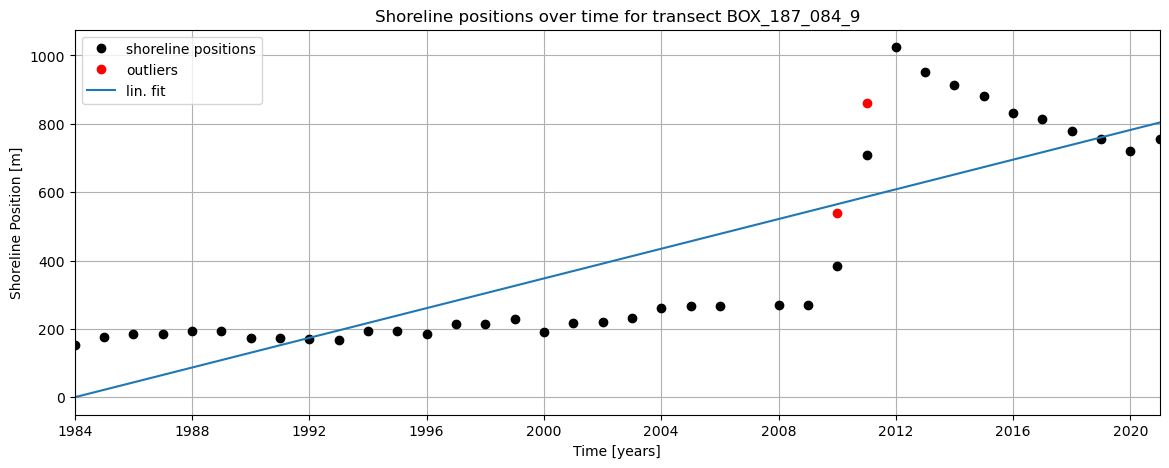

In [7]:
station = list(ds['transect_id'].values).index(b'BOX_187_084_9') # select station
# TODO: color the outlier
# TODO: add more info to the plot (sandy, uncertainty etc)

time_inds = np.array([i for i in range(len(ds.time.values))])
cr = ds.isel(stations=station)["changerate"].values
cr_unc = ds.isel(stations=station)["intercept"].values

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(ds.time, ds.isel(stations=station)["sp"].values - cr_unc, 'ko', label="shoreline positions")
outl_idx = [i for i,x in enumerate(ds.isel(stations= station)['outliers'].values) if x == 1]
outliers, outliers_time = ds.isel(stations=station)["sp"].values[outl_idx], ds.time[outl_idx]
ax.plot(outliers_time, outliers, 'ro', label="outliers")
ax.plot(ds.time, time_inds*cr, label="lin. fit")
ax.set_xlabel("Time [years]")
ax.set_ylabel("Shoreline Position [m]")
ax.set_title(
    "Shoreline positions over time for transect %s"%ds.isel(stations=station)["transect_id"].values.tolist().decode("utf-8") 
)
plt.grid()
plt.xlim(ds.time[0], ds.time[-1])
plt.legend();

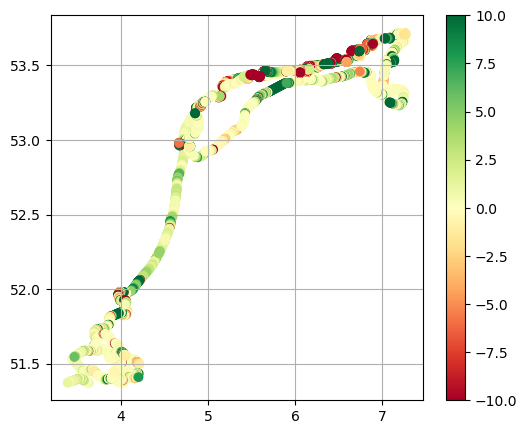

In [8]:
# trial: spatial slicing
# re-work dataset to filter on coords

min_lon = 3.369
min_lat = 51.372
max_lon = 7.275
max_lat = 53.727

# filtering on bbox values, note, slice does not work with lon & lat these are not gridded locations
bbox_bool = (ds.lon.values > min_lon) & (ds.lon.values < max_lon) & (ds.lat.values > min_lat) & (ds.lat.values < max_lat)
bbox_idx = list(compress(range(len(bbox_bool)), bbox_bool))
dsn = ds.isel(stations=bbox_idx)

# make figure
fig, ax = plt.subplots(figsize=(6, 5))
sc = ax.scatter(dsn.lon, dsn.lat, c=dsn.changerate, vmin=-10, vmax=10, cmap='RdYlGn')
plt.colorbar(sc)

plt.grid()

## 2. Monthly Shoreline Monitor

In [9]:
href = catalog.get_child("shore_mon_hr").assets["data"].href
ds_hr = xr.open_zarr(href)

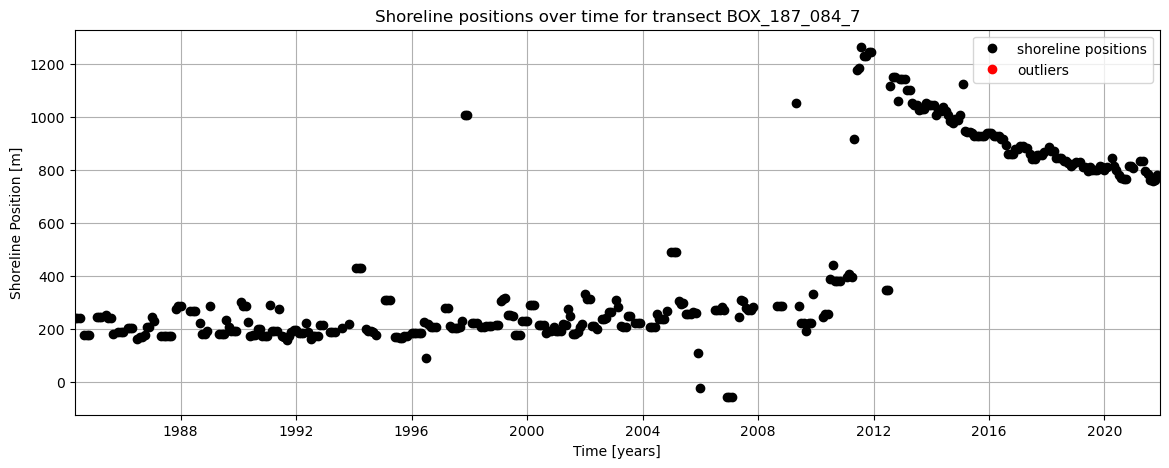

In [10]:
station = list(ds_hr['transect_id'].values).index(b'BOX_187_084_7') # select station
# TODO: color the outlier
# TODO: add more info to the plot (sandy, uncertainty etc)

time_inds = np.array([i for i in range(len(ds_hr.time.values))])
cr = ds_hr.isel(stations=station)["changerate"].values
# cr_unc = ds.isel(stations=station)["intercept"].values

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(ds_hr.time, ds_hr.isel(stations=station)["sp"].values, 'ko', label="shoreline positions")
outl_idx = [i for i,x in enumerate(ds_hr.isel(stations= station)['outliers'].values) if x == 1]
outliers, outliers_time = ds_hr.isel(stations=station)["sp"].values[outl_idx], ds_hr.time[outl_idx]
ax.plot(outliers_time, outliers, 'ro', label="outliers")
#ax.plot(ds.time, time_inds*cr + cr_unc, label="lin. fit")
ax.set_xlabel("Time [years]")
ax.set_ylabel("Shoreline Position [m]")
ax.set_title(
    "Shoreline positions over time for transect %s"%ds_hr.isel(stations=station)["transect_id"].values.tolist().decode("utf-8") 
)
plt.grid()
plt.xlim(ds_hr.time[0], ds_hr.time[-1])
plt.legend();

In [11]:
hotspot_id = ds_hr.isel(stations=station)["hotspot_id"].values
indices = np.where(ds_hr['hotspot_id'].values == hotspot_id)[0]

hotspot = ds_hr.isel(stations=indices)
hotspot

<xarray.Dataset>
Dimensions:        (stations: 27, time: 452)
Coordinates:
    hotspot_id     (stations) |S31 dask.array<chunksize=(27,), meta=np.ndarray>
    lat            (stations) float64 dask.array<chunksize=(27,), meta=np.ndarray>
    lon            (stations) float64 dask.array<chunksize=(27,), meta=np.ndarray>
  * time           (time) datetime64[ns] 1984-05-01 1984-06-01 ... 2021-12-01
    transect_geom  (stations) |S61 dask.array<chunksize=(27,), meta=np.ndarray>
    transect_id    (stations) |S15 dask.array<chunksize=(27,), meta=np.ndarray>
Dimensions without coordinates: stations
Data variables:
    changerate     (stations) float32 dask.array<chunksize=(27,), meta=np.ndarray>
    outliers       (stations, time) float32 dask.array<chunksize=(27, 57), meta=np.ndarray>
    sp             (stations, time) float64 dask.array<chunksize=(27, 57), meta=np.ndarray>
Attributes: (12/21)
    AUTHOR:              Kras, E., Van der Heijden, D. & Luijendijk, A.
    CITATION:            Kras, E. (2019). Planetary-scale classification of n...
    COMMENT:             
    CRS:                 EPSG:4326
    Conventions:         CF-1.8
    DESCRIPTION:         The Shoreline Monitor High Resolution is a dataset o...
    ...                  ...
    SPATIAL_EXTENT:      [-180, -90, 180, 90]
    TAGS:                ['civil engineering', 'geomorphology', 'shoreline dy...
    TEMPORAL_EXTENT:     ['1984-01-01T00:00:00Z', '2022-01-01T00:00:00Z']
    TITLE:               The Shoreline Monitor High Resolution
    TITLE_ABBREVIATION:  shore_mon_hr
    UNITS:

In [12]:
mean_dist = np.nanmean(hotspot['sp'].values, axis = 0)
distp90 = np.nanpercentile(hotspot['sp'].values, q = 95, axis = 0)
distp10 = np.nanpercentile(hotspot['sp'].values, q = 15, axis = 0)

C:\Users\heijd_de\AppData\Local\Temp\ipykernel_6632\2292402927.py:1: RuntimeWarning: Mean of empty slice
  mean_dist = np.nanmean(hotspot['sp'].values, axis = 0)
c:\Users\heijd_de\Anaconda3\envs\geo_env\lib\site-packages\numpy\lib\nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [13]:
from scipy.stats import linregress

varx = np.arange(0, len(mean_dist))
mask = ~np.isnan(mean_dist)
slope, intercept, r_value, p_value, std_err = linregress(varx[mask], mean_dist[mask])

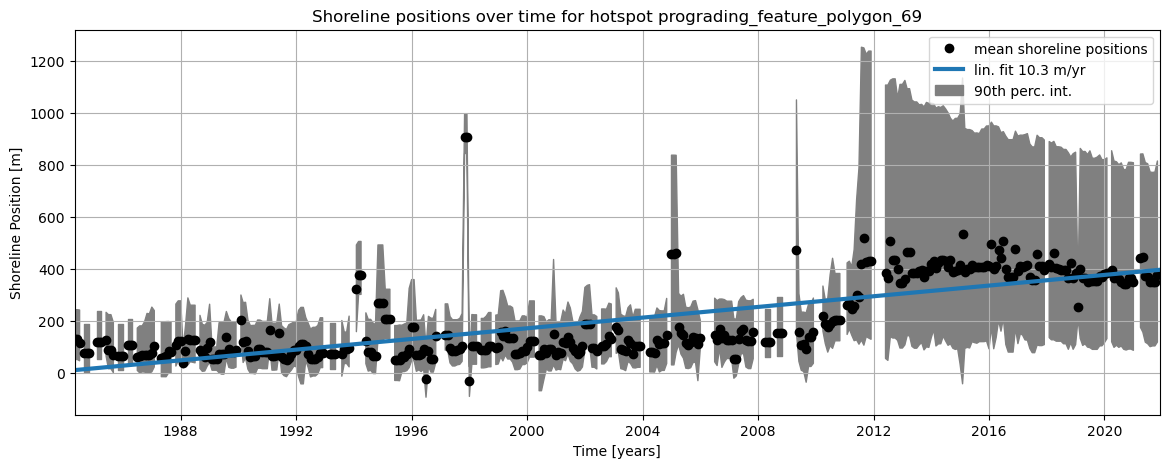

In [14]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(ds_hr.time, mean_dist, 'ko', label="mean shoreline positions")
ax.plot(ds_hr.time, varx*slope + intercept, linewidth = 3, label=f"lin. fit {round(slope*12, 1)} m/yr")
ax.fill_between(ds_hr.time, distp10,distp90,color= 'grey', label = '90th perc. int.')
ax.set_xlabel("Time [years]")
ax.set_ylabel("Shoreline Position [m]")
ax.set_title(
    f"Shoreline positions over time for hotspot %s"%ds_hr.isel(stations=station)["hotspot_id"].values.tolist().decode("utf-8") 
)
plt.grid()
plt.xlim(ds_hr.time[0], ds_hr.time[-1])
plt.legend()

In [15]:
transects = hotspot['transect_id'].values
indices = np.where(ds['transect_id'].isin(transects))[0]
hotspot_ann = ds.isel(stations=indices)

mean_dist = np.nanmean(hotspot_ann['sp'].values, axis = 0)
distp90 = np.nanpercentile(hotspot_ann['sp'].values, q = 95, axis = 0)
distp10 = np.nanpercentile(hotspot_ann['sp'].values, q = 15, axis = 0)

varx = np.arange(0, len(mean_dist))
mask = ~np.isnan(mean_dist)
slope, intercept, r_value, p_value, std_err = linregress(varx[mask], mean_dist[mask])

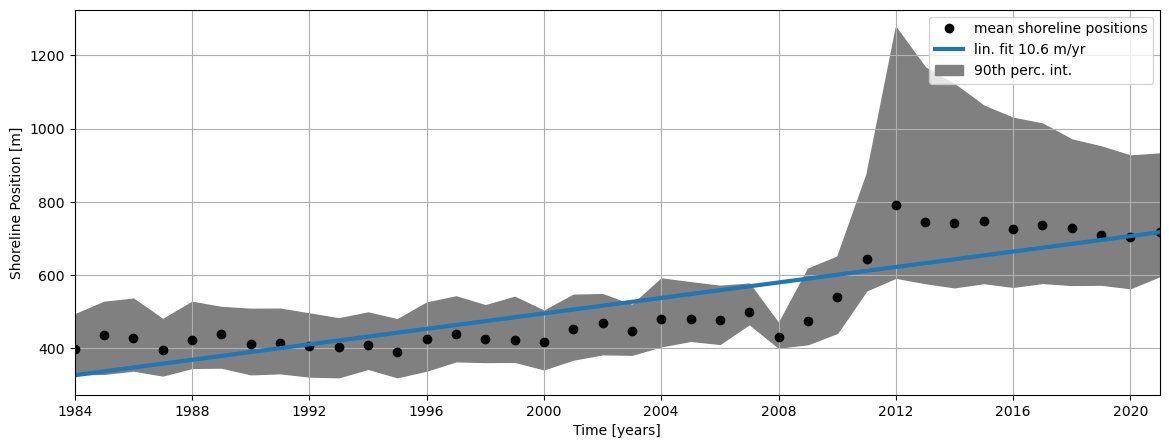

In [16]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(hotspot_ann.time, mean_dist, 'ko', label="mean shoreline positions")
ax.plot(hotspot_ann.time, varx*slope + intercept, linewidth = 3, label=f"lin. fit {round(slope, 1)} m/yr")
ax.fill_between(hotspot_ann.time, distp10,distp90,color= 'grey', label = '90th perc. int.')
ax.set_xlabel("Time [years]")
ax.set_ylabel("Shoreline Position [m]")
# ax.set_title(
#     f"Shoreline positions over time for hotspot %s"%ds.isel(stations=station)["hotspot_id"].values.tolist().decode("utf-8") 
# )
plt.grid()
plt.xlim(hotspot_ann.time[0], hotspot_ann.time[-1])
plt.legend()

## 3. Future projections

#### 3.1 Future projections with SLR

In [17]:
href = catalog.get_child("shore_mon_fut").assets["data"].href
ds_fut = xr.open_zarr(href)
ds_fut

<xarray.Dataset>
Dimensions:        (stations: 504815, time: 4)
Coordinates:
    continent      (stations) |S23 dask.array<chunksize=(31551,), meta=np.ndarray>
    country        (stations) |S40 dask.array<chunksize=(15776,), meta=np.ndarray>
    country_id     (stations) |S7 dask.array<chunksize=(63102,), meta=np.ndarray>
    lat            (stations) float64 dask.array<chunksize=(63102,), meta=np.ndarray>
    lon            (stations) float64 dask.array<chunksize=(63102,), meta=np.ndarray>
  * time           (time) datetime64[ns] 1984-01-01 2021-01-01 ... 2100-01-01
    transect_geom  (stations) |S92 dask.array<chunksize=(7888,), meta=np.ndarray>
    transect_id    (stations) |S15 dask.array<chunksize=(31551,), meta=np.ndarray>
Dimensions without coordinates: stations
Data variables:
    changerate     (stations) float64 dask.array<chunksize=(63102,), meta=np.ndarray>
    intercept      (stations) float64 dask.array<chunksize=(63102,), meta=np.ndarray>
    sp_ambient     (stations, time) float64 dask.array<chunksize=(63102, 1), meta=np.ndarray>
    sp_rcp45_p5    (stations, time) float64 dask.array<chunksize=(63102, 1), meta=np.ndarray>
    sp_rcp45_p50   (stations, time) float64 dask.array<chunksize=(63102, 1), meta=np.ndarray>
    sp_rcp45_p95   (stations, time) float64 dask.array<chunksize=(63102, 1), meta=np.ndarray>
    sp_rcp85_p5    (stations, time) float64 dask.array<chunksize=(63102, 1), meta=np.ndarray>
    sp_rcp85_p50   (stations, time) float64 dask.array<chunksize=(63102, 1), meta=np.ndarray>
    sp_rcp85_p95   (stations, time) float64 dask.array<chunksize=(63102, 1), meta=np.ndarray>
Attributes: (12/21)
    AUTHOR:              Vousdoukasm, M., Ranasinge., R & Mentaschi., L
    CITATION:            Vousdoukas, M. I., Ranasinghe, R., Mentaschi, L., Pl...
    COMMENT:             
    CRS:                 EPSG:4326
    Conventions:         CF-1.8
    DESCRIPTION:         The Shoreline Monitor Future Projections is a datase...
    ...                  ...
    SPATIAL_EXTENT:      [-180, -90, 180, 90]
    TAGS:                ['civil engineering', 'geomorphology', 'shoreline dy...
    TEMPORAL_EXTENT:     ['1984-01-01T00:00:00Z', '2021-01-01T00:00:00Z']
    TITLE:               The Shoreline Monitor Future Projections
    TITLE_ABBREVIATION:  shore_mon_fut
    UNITS:

In [18]:
ds_fut['time'].values

array(['1984-01-01T00:00:00.000000000', '2021-01-01T00:00:00.000000000',
       '2050-01-01T00:00:00.000000000', '2100-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

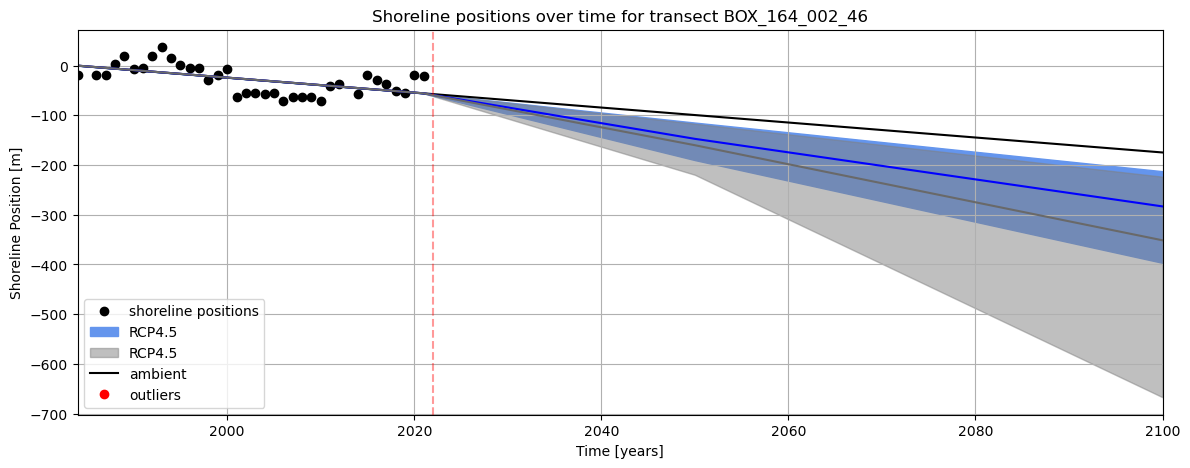

In [19]:
station = list(ds['transect_id'].values).index(b'BOX_164_002_46') # select station
station_fut = list(ds_fut['transect_id'].values).index(b'BOX_164_002_46')
# TODO: color the outlier
# TODO: add more info to the plot (sandy, uncertainty etc)

time_inds = np.array([i for i in range(len(ds.time.values))])
cr = ds.isel(stations=station)["changerate"].values
cr_unc = ds.isel(stations=station)["intercept"].values

fig, ax = plt.subplots(figsize=(14, 5))


ax.plot(ds.time, ds.isel(stations=station)["sp"].values - ds.isel(stations = station)['intercept'].values, 
        'ko', label="shoreline positions")


ax.fill_between(ds_fut.time, ds_fut.isel(stations=station_fut)["sp_rcp45_p5"].values,
                ds_fut.isel(stations=station_fut)["sp_rcp45_p95"].values,color= 'cornflowerblue', label = 'RCP4.5')
ax.fill_between(ds_fut.time, ds_fut.isel(stations=station_fut)["sp_rcp85_p5"].values,
                ds_fut.isel(stations=station_fut)["sp_rcp85_p95"].values,color= 'grey', alpha = 0.5, label = 'RCP4.5')
ax.plot(ds_fut.time, ds_fut.isel(stations=station_fut)["sp_ambient"].values, 'k', label="ambient")
ax.plot(ds_fut.time, ds_fut.isel(stations=station_fut)["sp_rcp45_p50"].values, color='blue')
ax.plot(ds_fut.time, ds_fut.isel(stations=station_fut)["sp_rcp85_p50"].values, color= 'dimgray')

outl_idx = [i for i,x in enumerate(ds.isel(stations= station)['outliers'].values) if x == 1]
outliers, outliers_time = ds.isel(stations=station)["sp"].values[outl_idx], ds.time[outl_idx]
ax.plot(outliers_time, outliers, 'ro', label="outliers")
ax.set_xlabel("Time [years]")
ax.set_ylabel("Shoreline Position [m]")
ax.set_title(
    "Shoreline positions over time for transect %s"%ds.isel(stations=station)["transect_id"].values.tolist().decode("utf-8") 
)
plt.grid()
plt.xlim(ds_fut.time[0], ds_fut.time[-1])
plt.axvline(pd.to_datetime('2022-01-01'), color = 'r', linestyle = '--', alpha= 0.4)
plt.legend();

#### 3.2 Short Term Machine Learning Projection

In [79]:
# https://builtin.com/data-science/time-series-forecasting-python

